# Full explanation : https://www.notion.so/Menyelamatkan-Profit-Superstore-dengan-Akurasi-MAPE-di-Bawah-15-2fd659dff8b380ee8a65c42118d5452c?source=copy_link

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from xgboost import XGBRegressor

In [ ]:

url = "https://raw.githubusercontent.com/asepsr37/data-and-machine-learning/main/classification/superstore-time-series/dataset/Superstore.csv"

df = pd.read_csv(
    url,
    encoding='latin1'
)

df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,13-06-2013,17-06-2013,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


#  Menentukan Object Data

In [ ]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

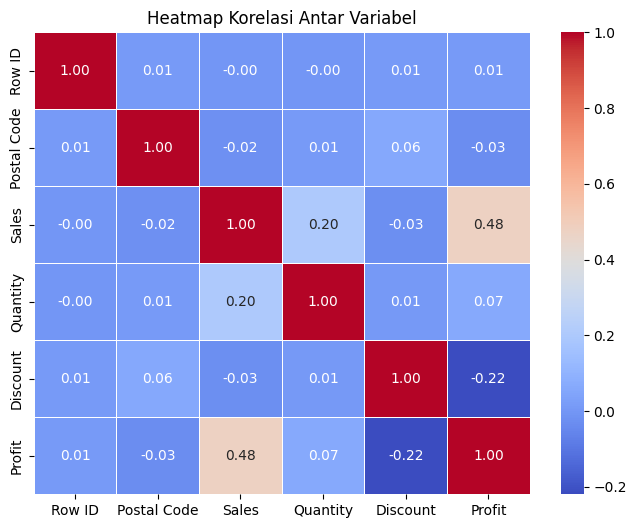

In [ ]:
# Korelasi Antar Table
df_numeric = df.select_dtypes(include='number')
corr_matrix = df_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Heatmap Korelasi Antar Variabel")
plt.show()

# Membersihkan Data

In [ ]:
df_clean = df.copy()

In [ ]:
# Mengubah Kolom menjadi tidak kapial dan menghapus spasi
df_clean.columns = (df_clean.columns.str.lower().str.replace(' ','_').str.replace('-','_'))

print(f"Kondisi Kolom sebelum pembersihan : {df.columns}\n")
print(f"Kondisi Kolom sesudah pembersihan : {df_clean.columns}")

Kondisi Kolom sebelum pembersihan : Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

Kondisi Kolom sesudah pembersihan : Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')


In [ ]:
# mengubah tipe data kolom tanggal dari object menjadi datetime
date_cols = ['order_date', 'ship_date']
df_clean[date_cols] = df_clean[date_cols].apply(
    pd.to_datetime,
    dayfirst = True,
    errors = 'coerce'
)

date_cols_raw = ['Order Date', 'Ship Date']
date_cols_clean = ['order_date', 'ship_date']

print("Sebelum perubahan tipe data (df):")
print(df[date_cols_raw].dtypes)

print("\nSesudah perubahan tipe data (df_clean):")
print(df_clean[date_cols_clean].dtypes)


Sebelum perubahan tipe data (df):
Order Date    object
Ship Date     object
dtype: object

Sesudah perubahan tipe data (df_clean):
order_date    datetime64[ns]
ship_date     datetime64[ns]
dtype: object


In [ ]:
# Menghapus baris nilai kurang dari 1 pada sales
df_clean.drop(
    df_clean[df_clean['sales'] < 1].index,
    inplace=True)

print(f"sebelum penghapus data pada sales {df.shape}")
print(f"Sesudah penghapus data pada sales {df_clean.shape}")

sebelum penghapus data pada sales (9994, 21)
Sesudah penghapus data pada sales (9986, 21)


In [ ]:
# Hapus baris Discount ≥ 0.5 karena pada rentang tersebut adalah outliers
df_clean.drop(
    df_clean[df_clean['discount'] >= 0.5].index,
    inplace=True
)

print(f"sebelum penghapus data pada Outliers {df.shape}")
print(f"Sesudah penghapus data pada Outliers {df_clean.shape}")

sebelum penghapus data pada Outliers (9994, 21)
Sesudah penghapus data pada Outliers (9071, 21)


In [ ]:
# pembulatan pada sales dan profit
df_clean['sales'] = df_clean['sales'].round().astype(int)
df_clean['profit'] = df_clean['profit'].round().astype(int)

In [ ]:
# daftar kolom identifikasi yang tidak digunakan untuk model
cols_to_drop = [
    'row_id',
    'order_id',
    'customer_id',
    'product_id',
    'customer_name',
    'product_name',
    'country',
    'city',
    'postal_code'
]

# hapus kolom
df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')


In [ ]:
# set order_date sebagai index
df_clean = df_clean.set_index('order_date')
df_clean = df_clean.sort_index()

In [ ]:
df_clean

,ship_date,ship_mode,segment,state,region,category,sub_category,sales,quantity,discount,profit
order_date,,,,,,,,,,,
2011-01-04,2011-01-08,Standard Class,Consumer,Texas,Central,Office Supplies,Paper,16,2,0.2,6
2011-01-05,2011-01-09,Standard Class,Home Office,Illinois,Central,Office Supplies,Storage,273,3,0.2,-65
2011-01-05,2011-01-09,Standard Class,Home Office,Illinois,Central,Office Supplies,Labels,12,3,0.2,4
2011-01-06,2011-01-13,Standard Class,Consumer,Pennsylvania,East,Office Supplies,Art,20,3,0.2,5
2011-01-07,2011-01-11,Standard Class,Home Office,Kentucky,South,Technology,Phones,756,4,0.0,204
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31,2015-01-04,Standard Class,Consumer,New York,East,Technology,Phones,91,7,0.0,3
2014-12-31,2015-01-04,Standard Class,Consumer,New York,East,Furniture,Bookcases,323,4,0.2,12
2014-12-31,2015-01-04,Standard Class,Corporate,California,West,Office Supplies,Binders,14,2,0.2,5


# Mengontruksi Data

In [ ]:
# Agregasi Data
df_monthly = df_clean.resample('MS').agg({
    'sales': 'sum',
    'quantity': 'sum',
    'profit': 'sum',
    'discount': 'mean'
})
df_monthly.index = df_monthly.index.to_period('M')

# Menampilkan hasil
print(f"Jumlah baris setelah agregasi: {len(df_monthly)}")

df_monthly

Jumlah baris setelah agregasi: 48


,sales,quantity,profit,discount
order_date,,,,
2011-01,13492,246,2987,0.052899
2011-02,4735,139,937,0.073750
2011-03,31519,526,3152,0.118881
2011-04,27729,509,3941,0.091985
2011-05,22221,417,3988,0.104054
2011-06,33923,474,5539,0.110083
2011-07,31618,493,3038,0.115000
2011-08,26998,565,6021,0.090559
2011-09,75992,904,12210,0.101116


In [ ]:
# Membuat sales bulan lalu (Lag 1)
df_monthly['lag_1'] = df_monthly['sales'].shift(1)

# Membuat sales 2 bulan lalu (Lag 2)
df_monthly['lag_2'] = df_monthly['sales'].shift(2)

# Membuat sales 3 bulan lalu (Lag 3) - Cocok karena target prediksi kamu 3 bulan
df_monthly['lag_3'] = df_monthly['sales'].shift(3)

df_monthly


,sales,quantity,profit,discount,lag_1,lag_2,lag_3
order_date,,,,,,,
2011-01,13492,246,2987,0.052899,NaN,NaN,NaN
2011-02,4735,139,937,0.073750,13492.0,NaN,NaN
2011-03,31519,526,3152,0.118881,4735.0,13492.0,NaN
2011-04,27729,509,3941,0.091985,31519.0,4735.0,13492.0
2011-05,22221,417,3988,0.104054,27729.0,31519.0,4735.0
2011-06,33923,474,5539,0.110083,22221.0,27729.0,31519.0
2011-07,31618,493,3038,0.115000,33923.0,22221.0,27729.0
2011-08,26998,565,6021,0.090559,31618.0,33923.0,22221.0
2011-09,75992,904,12210,0.101116,26998.0,31618.0,33923.0


In [ ]:
# Rata-rata penjualan 3 bulan terakhir (Moving Average)
df_monthly['rolling_mean_3'] = df_monthly['sales'].shift(1).rolling(window=3).mean()

# Nilai maksimal dalam 3 bulan terakhir
df_monthly['rolling_max_3'] = df_monthly['sales'].shift(1).rolling(window=3).max()

df_monthly

,sales,quantity,profit,discount,lag_1,lag_2,lag_3,rolling_mean_3,rolling_max_3
order_date,,,,,,,,,
2011-01,13492,246,2987,0.052899,NaN,NaN,NaN,NaN,NaN
2011-02,4735,139,937,0.073750,13492.0,NaN,NaN,NaN,NaN
2011-03,31519,526,3152,0.118881,4735.0,13492.0,NaN,NaN,NaN
2011-04,27729,509,3941,0.091985,31519.0,4735.0,13492.0,16582.000000,31519.0
2011-05,22221,417,3988,0.104054,27729.0,31519.0,4735.0,21327.666667,31519.0
2011-06,33923,474,5539,0.110083,22221.0,27729.0,31519.0,27156.333333,31519.0
2011-07,31618,493,3038,0.115000,33923.0,22221.0,27729.0,27957.666667,33923.0
2011-08,26998,565,6021,0.090559,31618.0,33923.0,22221.0,29254.000000,33923.0
2011-09,75992,904,12210,0.101116,26998.0,31618.0,33923.0,30846.333333,33923.0


In [ ]:
# Ekstrak bulan dan kuartal dari index
df_monthly['month'] = df_monthly.index.month
df_monthly['quarter'] = df_monthly.index.quarter
df_monthly['year'] = df_monthly.index.year

df_monthly

,sales,quantity,profit,discount,lag_1,lag_2,lag_3,rolling_mean_3,rolling_max_3,month,quarter,year
order_date,,,,,,,,,,,,
2011-01,13492,246,2987,0.052899,NaN,NaN,NaN,NaN,NaN,1,1,2011
2011-02,4735,139,937,0.073750,13492.0,NaN,NaN,NaN,NaN,2,1,2011
2011-03,31519,526,3152,0.118881,4735.0,13492.0,NaN,NaN,NaN,3,1,2011
2011-04,27729,509,3941,0.091985,31519.0,4735.0,13492.0,16582.000000,31519.0,4,2,2011
2011-05,22221,417,3988,0.104054,27729.0,31519.0,4735.0,21327.666667,31519.0,5,2,2011
2011-06,33923,474,5539,0.110083,22221.0,27729.0,31519.0,27156.333333,31519.0,6,2,2011
2011-07,31618,493,3038,0.115000,33923.0,22221.0,27729.0,27957.666667,33923.0,7,3,2011
2011-08,26998,565,6021,0.090559,31618.0,33923.0,22221.0,29254.000000,33923.0,8,3,2011
2011-09,75992,904,12210,0.101116,26998.0,31618.0,33923.0,30846.333333,33923.0,9,3,2011


Algoritma Machine Learning (seperti XGBoost) tidak bisa membaca format tanggal (seperti 2014-12-31) sebagai input matematika. Mereka hanya mengerti angka. Dengan memecah tanggal menjadi kolom month, quarter, dan year, kamu mengubah informasi waktu yang abstrak menjadi sinyal numerik yang bisa diproses oleh algoritma.

In [ ]:
# Menghapus baris yang memiliki nilai NaN
df_monthly_final = df_monthly.dropna()

# Cek kembali apakah masih ada NaN
print(df_monthly_final.isnull().sum())
print(f"Jumlah baris sekarang: {len(df_monthly_final)}")

sales             0
quantity          0
profit            0
discount          0
lag_1             0
lag_2             0
lag_3             0
rolling_mean_3    0
rolling_max_3     0
month             0
quarter           0
year              0
dtype: int64
Jumlah baris sekarang: 45


In [ ]:
df_monthly_final

,sales,quantity,profit,discount,lag_1,lag_2,lag_3,rolling_mean_3,rolling_max_3,month,quarter,year
order_date,,,,,,,,,,,,
2011-04,27729,509,3941,0.091985,31519.0,4735.0,13492.0,16582.000000,31519.0,4,2,2011
2011-05,22221,417,3988,0.104054,27729.0,31519.0,4735.0,21327.666667,31519.0,5,2,2011
2011-06,33923,474,5539,0.110083,22221.0,27729.0,31519.0,27156.333333,31519.0,6,2,2011
2011-07,31618,493,3038,0.115000,33923.0,22221.0,27729.0,27957.666667,33923.0,7,3,2011
2011-08,26998,565,6021,0.090559,31618.0,33923.0,22221.0,29254.000000,33923.0,8,3,2011
2011-09,75992,904,12210,0.101116,26998.0,31618.0,33923.0,30846.333333,33923.0,9,3,2011
2011-10,31236,539,3631,0.112585,75992.0,26998.0,31618.0,44869.333333,75992.0,10,4,2011
2011-11,76455,1122,11644,0.099207,31236.0,75992.0,26998.0,44742.000000,75992.0,11,4,2011
2011-12,66706,961,11391,0.118724,76455.0,31236.0,75992.0,61227.666667,76455.0,12,4,2011


In [ ]:
df_monthly_after_feature_engineering = df_monthly_final.copy()
df_monthly_without_feature_engineering = df_monthly.copy()

In [ ]:
# Karena target prediksi adalah 3 bulan, test_size = 3
test_size = 3

# Split setelah feature engineering
train_ml, test_ml = train_test_split(
    df_monthly_after_feature_engineering,
    test_size=test_size,
    shuffle=False
)

# Split tanpa feature engineering
train_stat, test_stat = train_test_split(
    df_monthly_without_feature_engineering,
    test_size=test_size,
    shuffle=False
)

print(f"Jumlah Data Latih XGBOOST: {len(train_ml)}")
print(f"Jumlah Data Uji XGBOOST: {len(test_ml)}")

print(f"Jumlah Data Latih Arima dan Exponential Smoothing: {len(train_stat)}")
print(f"Jumlah Data Uji Arima dan Exponential Smoothing: {len(test_stat)}")

Jumlah Data Latih XGBOOST: 42
Jumlah Data Uji XGBOOST: 3
Jumlah Data Latih Arima dan Exponential Smoothing: 45
Jumlah Data Uji Arima dan Exponential Smoothing: 3


# Membuat Skenario Model

In [ ]:
# Algoritma XGBost
X_train = train_ml.drop(columns=['sales'])
y_train = train_ml['sales']
X_test = test_ml.drop(columns=['sales'])
y_test = test_ml['sales']

# Inisialisasi dan Training
# n_estimators: jumlah pohon, learning_rate : kecepatan belajar
model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train)

# Prediksi
forecast_xgb = model_xgb.predict(X_test)

print("Model XGBoost selesai dilatih!")

Model XGBoost selesai dilatih!


In [ ]:
# Algoritma ARIMA
model_arima = pm.auto_arima(
    train_stat['sales'],
    seasonal=True,
    m=12,          # Periode musiman bulanan
    stepwise=True,
    suppress_warnings=True
)

# Prediksi untuk 3 bulan
forecast_arima = model_arima.predict(n_periods=len(test_stat))

print(f"Model ARIMA selesai. Parameter terbaik: {model_arima.order}")

Model ARIMA selesai. Parameter terbaik: (0, 0, 0)


In [ ]:
# Algoritmma Exponetial Smoothing
model_hw = ExponentialSmoothing(
    train_stat['sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# Prediksi untuk 3 bulan ke depan (sesuai test_size)
forecast_hw = model_hw.forecast(len(test_stat))

print("Model Holt-Winters berhasil dilatih!")


Model Holt-Winters berhasil dilatih!


# Evaluasi

In [ ]:
# Akurasi
def calculate_mape(actual, forecast):
    forecast = np.array(forecast).flatten()
    actual = np.array(actual)
    return np.mean(np.abs((actual - forecast) / actual)) * 100


# Hitung MAPE tiap model
mape_hw = calculate_mape(test_stat['sales'], forecast_hw)
mape_arima = calculate_mape(test_stat['sales'], forecast_arima)
mape_xgb = calculate_mape(y_test.values, forecast_xgb)


# Buat tabel perbandingan
mape_table = pd.DataFrame({
    'Model': ['Holt-Winters', 'ARIMA', 'XGBoost'],
    'MAPE (%)': [mape_hw, mape_arima, mape_xgb]
})

# Pembulatan biar rapi
mape_table['MAPE (%)'] = mape_table['MAPE (%)'].round(2)

mape_table

,Model,MAPE (%)
0,Holt-Winters,15.27
1,ARIMA,17.12
2,XGBoost,5.07


# Deployment

In [ ]:

# 1. Ambil data terakhir sebagai titik awal
last_data = df_monthly_after_feature_engineering.iloc[-1:].copy()
future_predictions = []

# Ambil index terakhir (yang bertipe Period)
current_period = last_data.index[0]

# 2. Loop untuk memprediksi 3 bulan ke depan
for i in range(1, 4):
    # Untuk tipe Period, cukup tambah integer untuk loncat bulan
    next_period = current_period + i

    new_row = {}

    # Fitur Waktu (diambil langsung dari atribut Period)
    new_row['month'] = next_period.month
    new_row['quarter'] = next_period.quarter
    new_row['year'] = next_period.year

    # Fitur Statistik (Gunakan median dari data historis)
    new_row['quantity'] = df_monthly_after_feature_engineering['quantity'].median()
    new_row['profit'] = df_monthly_after_feature_engineering['profit'].median()
    new_row['discount'] = df_monthly_after_feature_engineering['discount'].median()

    # Logika Recursive Lag
    if i == 1:
        new_row['lag_1'] = last_data['sales'].values[0]
        new_row['lag_2'] = last_data['lag_1'].values[0]
        new_row['lag_3'] = last_data['lag_2'].values[0]
    elif i == 2:
        new_row['lag_1'] = future_predictions[0]
        new_row['lag_2'] = last_data['sales'].values[0]
        new_row['lag_3'] = last_data['lag_1'].values[0]
    else: # i == 3
        new_row['lag_1'] = future_predictions[1]
        new_row['lag_2'] = future_predictions[0]
        new_row['lag_3'] = last_data['sales'].values[0]

    # Fitur Rolling
    lags = [new_row['lag_1'], new_row['lag_2'], new_row['lag_3']]
    new_row['rolling_mean_3'] = np.mean(lags)
    new_row['rolling_max_3'] = np.max(lags)

    # Prediksi
    X_future = pd.DataFrame([new_row])[X_train.columns]
    pred_sales = model_xgb.predict(X_future)[0]

    future_predictions.append(pred_sales)

# 3. Buat DataFrame Hasil
forecast_df = pd.DataFrame({
    'Period': [current_period + i for i in range(1, 4)],
    'Predicted_Sales': future_predictions
})

print("Hasil Prediksi 3 Bulan ke Depan:")
print(forecast_df)

Hasil Prediksi 3 Bulan ke Depan:
    Period  Predicted_Sales
0  2015-01     39945.707031
1  2015-02     37600.921875
2  2015-03     37545.832031


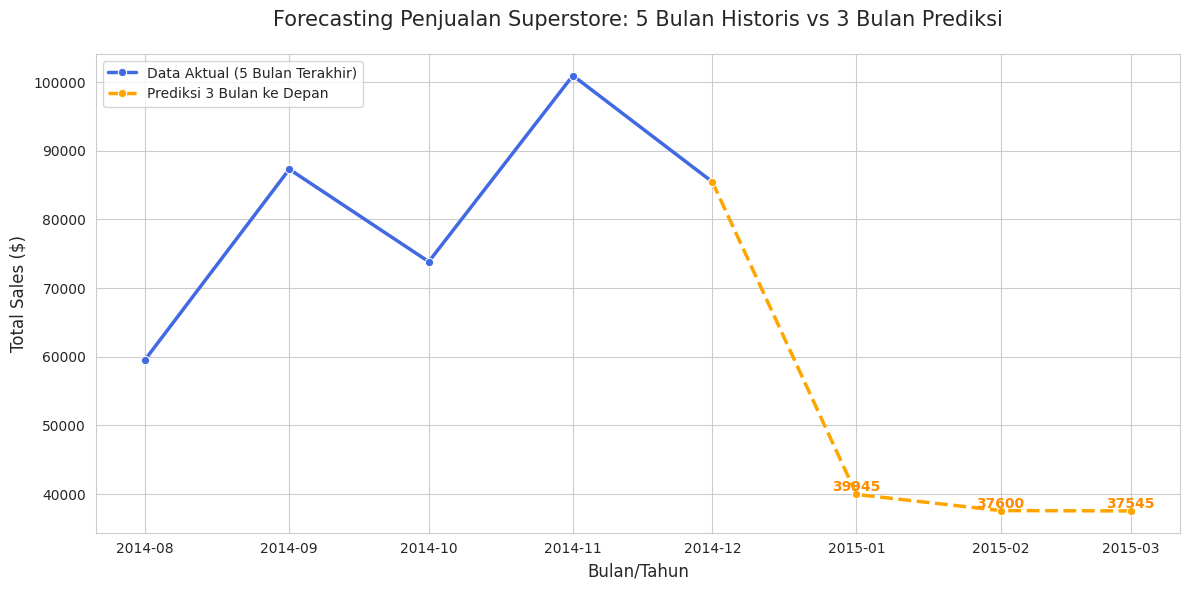

In [ ]:
# 1. Persiapan Data Historis (5 bulan terakhir)
history_to_plot = df_monthly_after_feature_engineering.tail(5)[['sales']].copy()
history_to_plot.index = history_to_plot.index.to_timestamp() # Ubah Period ke Timestamp untuk plotting
history_to_plot['Type'] = 'Data Aktual'

# 2. Persiapan Data Prediksi (3 bulan ke depan)
forecast_to_plot = forecast_df.copy()
forecast_to_plot.columns = ['date', 'sales']
forecast_to_plot['date'] = forecast_to_plot['date'].dt.to_timestamp() # Ubah Period ke Timestamp
forecast_to_plot.set_index('date', inplace=True)
forecast_to_plot['Type'] = 'Prediksi XGBoost'

# 3. Gabungkan data terakhir dari history dengan data pertama dari forecast
# agar garis di chart menyambung sempurna
bridge = history_to_plot.tail(1).copy()
bridge['Type'] = 'Prediksi XGBoost'
forecast_combined = pd.concat([bridge, forecast_to_plot])

# 4. Plotting
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot Data Aktual
sns.lineplot(data=history_to_plot, x=history_to_plot.index, y='sales',
             marker='o', label='Data Aktual (5 Bulan Terakhir)', color='royalblue', linewidth=2.5)

# Plot Data Prediksi
sns.lineplot(data=forecast_combined, x=forecast_combined.index, y='sales',
             marker='o', label='Prediksi 3 Bulan ke Depan', color='orange', linestyle='--', linewidth=2.5)

# Anotasi angka pada titik prediksi
for x, y in zip(forecast_to_plot.index, forecast_to_plot['sales']):
    plt.text(x, y, f'{int(y)}', color='darkorange', fontweight='bold', va='bottom', ha='center')

# Styling Chart
plt.title('Forecasting Penjualan Superstore: 5 Bulan Historis vs 3 Bulan Prediksi', fontsize=15, pad=20)
plt.xlabel('Bulan/Tahun', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()